# Semantic segmentation with U-Net

- U-Net is an architecture developed to generate mapping between images and correspoding masks for each image.
- It was developed for 'few shot' learning: making a reliable model with few training examples.
- Original U-net paper (https://arxiv.org/abs/1505.04597)

# About the data

The seismic data used in this exercise is from the Kerry 3D data set offshore New Zealand: https://dataunderground.org/dataset/kerry. You do not need to download the entire dataset for this exercise. The training images have already been created for you.

The training data consists of a series of subsections (tiles) along inlines across the volume. The modeled fault regions where picked using Microsoft's Visual Object Tagging Tool, https://github.com/microsoft/VoTT. 

First we'll import the usual supporting libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, BatchNormalization, Activation, Dense, Dropout,
                                    Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose,
                                    MaxPooling2D, GlobalMaxPool2D, UpSampling2D, concatenate, add)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import (array_to_img, img_to_array,
                                                 load_img)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
def cross_entropy_balanced(y_true, y_pred):
    # Implementation from https://github.com/xinwucwp/faultSeg
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(tf.keras.backend.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.math.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def little_unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=3)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=3)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=3)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    conv8 = Conv2D(1, (1,1), activation='sigmoid')(conv7)

    model = Model(inputs, conv8)

    model.compile(optimizer = Adam(lr = 1e-4), loss = cross_entropy_balanced, metrics = ['accuracy'])

    return model

To generate more samples from the training dataset we have, we can use an ImageDataGenerator object. This object can be parametrized to produce more samples for training automatically.

In [9]:
aug_args = dict(rotation_range=0.2,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                fill_mode='nearest')

In [22]:
def scaleData(img, mask):
    """Helper function to normalize images and masks.
    It also binarizes the mask.
    """
    img = img / 255
    mask = mask > 127
    return img, mask

def trainGenerator(train_path, image_folder, mask_folder, aug_dict, seed = 1):
    """Produces samples of training images from the train pool of images.
    I can generate infinite samples based on the augmentation parameters.
    """

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = (256,256),
        batch_size = 2,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = (256,256),
        batch_size = 2,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for img, mask in train_generator:
        img, mask = scaleData(img, mask)
        yield img, mask

We initialize and store the data generation object that will feed the network. 

In [23]:
data_gen = trainGenerator('../data/faultpick/', 'seismic', 'fault', aug_args)

Initialize the network.

In [24]:
model = little_unet()
model_checkpoint = ModelCheckpoint('seis_unet.hdf5', monitor='loss', 
                                   verbose=1, save_best_only=True,
                                   save_weights_only=True)

Train the network.

In [25]:
model.fit(data_gen, steps_per_epoch=50, epochs=5, callbacks=[model_checkpoint])

Found 122 images belonging to 1 classes.
Found 122 images belonging to 1 classes.
Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.4904
Epoch 00001: loss improved from inf to 0.08748, saving model to seis_unet.hdf5
50/50 [==============================] - 58s 1s/step - loss: 0.0875 - accuracy: 0.4904
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.6069
Epoch 00002: loss improved from 0.08748 to 0.08287, saving model to seis_unet.hdf5
50/50 [==============================] - 63s 1s/step - loss: 0.0829 - accuracy: 0.6069
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.6338
Epoch 00003: loss did not improve from 0.08287
50/50 [==============================] - 62s 1s/step - loss: 0.0939 - accuracy: 0.6338
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.6576
Epoch 00004: loss improved from 0.08287 to 0.06002, saving model to seis_une

### EXERCISE

Write a workflow to make predictions from the images in `'../data/faultpick/test/'` using the model trained.

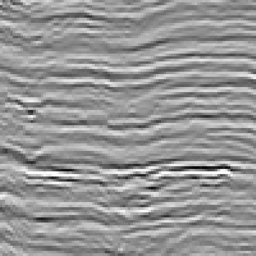

In [19]:
img = Image.open('../data/faultpick/test/section_166_1_inline.png')
img = img.resize((256,256))
img

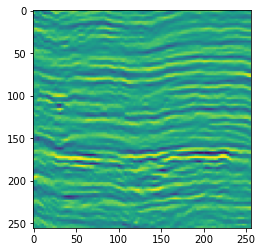

In [21]:
img_arr = np.array(img, dtype=float)[:,:,0]
img_arr /= 255.0

plt.imshow(img_arr)

In [16]:
prediction = model.predict(img_arr.reshape(1, 256, 256, 1))

In [17]:
prediction = prediction.reshape((256,256))

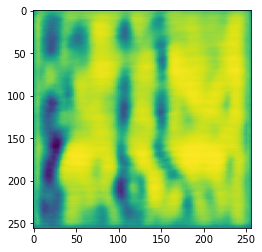

In [18]:
plt.imshow(prediction)